## 协同过滤——隐式评级及基于物品的过滤
使用基于用户的协同过滤算法时，用户对不同物品给出一个5分区间或10分区间的评分，之后算法可以发现具有类似评分的其他用户。前面提到，有一些证据表明，用户通常不使用这种细粒度的区分机制，而是倾向于要不给最高评分要不给最低评分。这种非此即彼的极端评级方式有时可能会导致结果无法使用。本章将考察对协同过滤的调优方法，以便更高效地产生更精确的推荐结果。

### 显式评级
显式评级是指用户显式地给出物品的评级结果。

### 隐式评级
对于隐式评级而言，我们不要求用户给出任何评级得分，而是观察用户的行为来获得结果。一个例子是跟踪用户在纽约时报在线（online New York Times）上的点击轨迹。

#### 显式评级的问题
- 用户大都具有惰性，不愿意对物品评级
- 用户可能撒谎或者只给出部分信息
- 用户不会更新其评级结果

#### 基于用户的过滤
基于用户的协同过滤有两个主要问题：
1. 扩展性：随着用户数目的增长，计算量也会增长。基于用户的方法在几千用户时效果还好，但是有上百万用户时扩展性就成为一个问题
2. 稀疏性：大部分推荐系统中，用户和商品都很多，但是用户评级的平均商品数目却较少。例如，Amazon有几百万本图书，但是平均每个用户评级过的图书数目只有极小一部分。因此，第2章介绍的算法可能找不到最近邻居

基于上述两种原因，最好采用如下所谓基于物品的过滤。

#### 基于物品的过滤
在基于用户的过滤中，给定某个用户，我们寻找与其最相似的用户（或多个用户），并利用他们的评级结果来进行推荐。而在基于物品的推荐中，我们事先找到最相似的物品，并结合用户对物品的评级结果来生成推荐。

假设我们的流音乐网站有m个用户和n个乐队，用户对乐队评级结果在下表中给出:

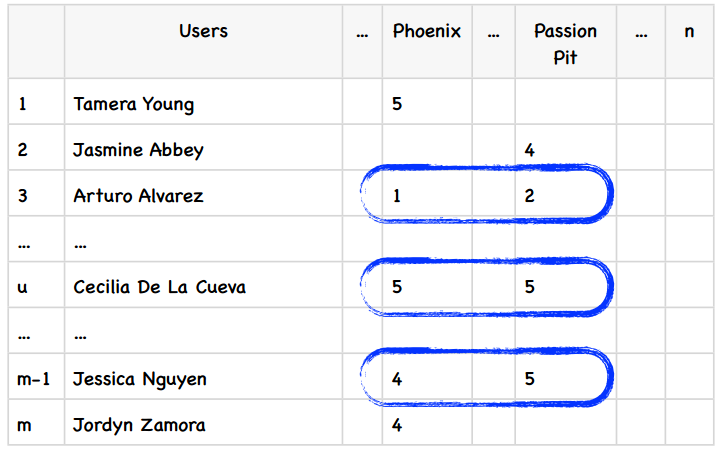

我们要计算Phoenix和Passion Pit的相似度。为实现这一点，我们只使用同时对两个乐队评过级的用户。如果进行基于用户的过滤，我们要确定行之间的相似度。而对于基于物品的过滤，我们要确定列之间的相似度，这里就是Phoenix和Passion Pit所在列的相似度。

### 调整后的余弦相似度
为计算物品之间的相似度，我们使用第2章介绍过的余弦相似度。我们也提到当用户给出的评级都高于预期时会出现“分数贬值”（或者说分数夸大，指分数很高超过实际应得的分数）现象。为了抵消分数贬值的后果，我们会从每个评级结果中减去平均的评级结果。这样做之后就得到下面给出的调整后的余弦相似度计算公式：
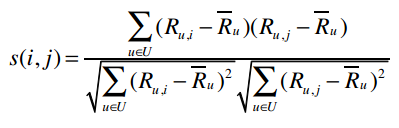

$s(i,j)$表示我们寻找物品i和物品j之间的相似度。

$(R_{u,j}-\overline{R_u})$指的是用户u给物品i的评分减去用户u对所有物品的评分的平均值。这样可以得到归一化的评级结果。

为了展示调整后余弦相似度的计算效果，我们将使用下列5名学生对5个乐队的评级数据：
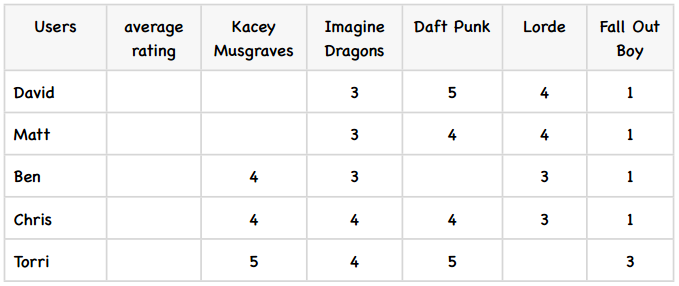

第一件事是计算每个用户的平均评分：
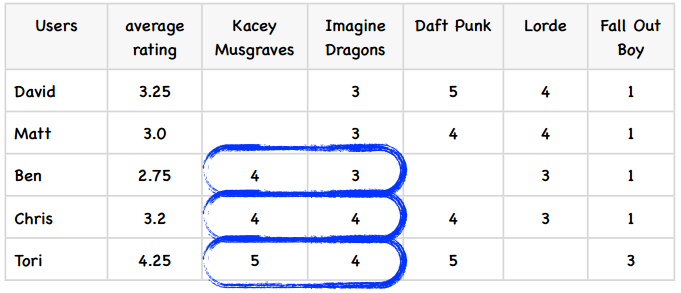

首先计算Kacey Musgraves和Imagine Dragons的相似度：
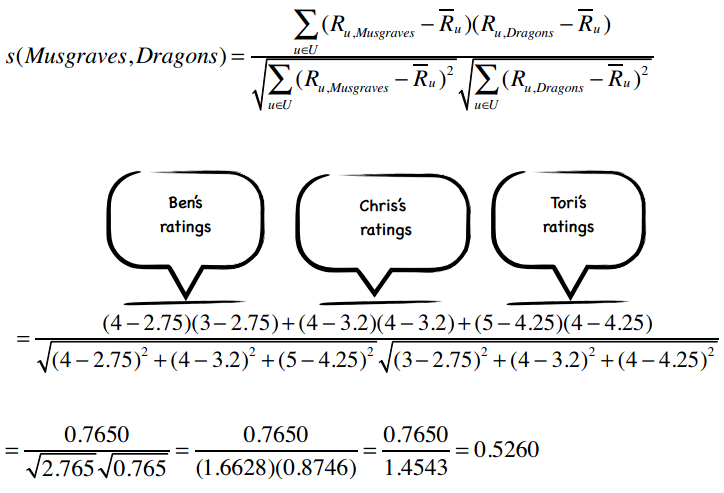

计算所有的相似度：
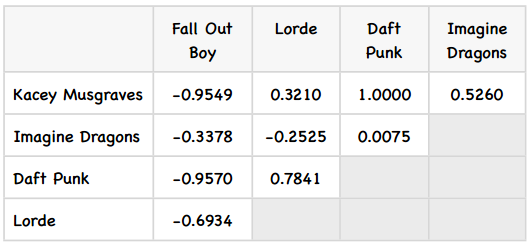

代码如下：

In [1]:
from math import sqrt

users3 = {"David": {"Imagine Dragons": 3, "Daft Punk": 5, "Lorde": 4, "Fall Out Boy": 1},
          "Matt": {"Imagine Dragons": 3, "Daft Punk": 4, "Lorde": 4, "Fall Out Boy": 1},
          "Ben": {"Kacey Musgraves": 4, "Imagine Dragons": 3, "Lorde": 3, "Fall Out Boy": 1},
          "Chris": {"Kacey Musgraves": 4, "Imagine Dragons": 4, "Daft Punk": 4, "Lorde": 3, "Fall Out Boy": 1},
          "Tori": {"Kacey Musgraves": 5, "Imagine Dragons": 4, "Daft Punk": 5, "Fall Out Boy": 3}}

def computeSimilarity(band1, band2, userRatings):
    averages = {}
    for (key, ratings) in userRatings.items():
        averages[key] = (float(sum(ratings.values())) / len(ratings.values()))

    num = 0 # 分子
    dem1 = 0 # 分母的第一部分
    dem2 = 0
    for (user, ratings) in userRatings.items():
        if band1 in ratings and band2 in ratings:
            avg = averages[user]
            num += (ratings[band1] - avg) * (ratings[band2] - avg)
            dem1 += (ratings[band1] - avg) ** 2
            dem2 += (ratings[band2] - avg) ** 2
    return num / (sqrt(dem1) * sqrt(dem2))

print(computeSimilarity('Kacey Musgraves', 'Lorde', users3))
print(computeSimilarity('Imagine Dragons', 'Lorde', users3))
print(computeSimilarity('Daft Punk', 'Lorde', users3))

0.320959291340884
-0.2525265372291518
0.7841149584671063


根据矩阵做预测，比如我想知道David有多喜欢Kacey Musgraves？公式如下：
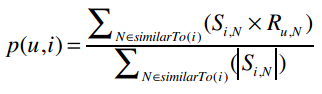

$p(u,i)$表示我们会来预测用户$u$对物品$i$的评分，所以$p(David, Kacey Musgraves)$就表示我们将预测David会给Kacey打多少分。

$N$是一个物品的集合，有如下特性：
- 用户$u$对集合中的物品打过分
- 物品$i$和集合中的物品有相似度数据（即上文中的矩阵）

$S_{i,N}$表示物品i和N的相似度，$R_{u,N}$表示用户$u$对物品$N$的评分。

为了让公式的计算效果更佳，对物品的评价分值最好介于-1和1之间。由于我们的评分系统是1至5星，所以需要使用一些运算将其转换到-1至1之间：
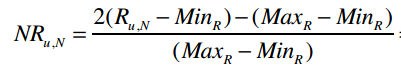

而将上述归一化结果还原到原始1分到5分范围的公式如下：
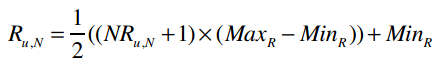

比如一位用户给Fall Out Boy打了2分，那修正后的评分为：
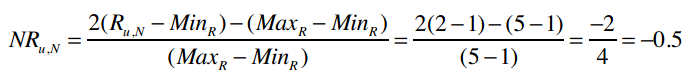

反向计算：
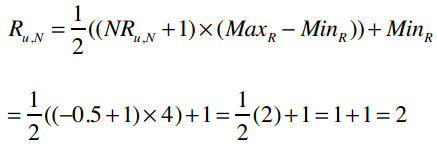

有了这个基础后，下面就让我们看看如何求解上文中的p(David, Kacey Musgraves)。

首先我们要修正David对各个物品的评分：
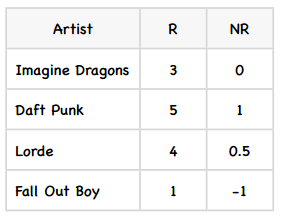

然后结合物品相似度矩阵，代入公式：
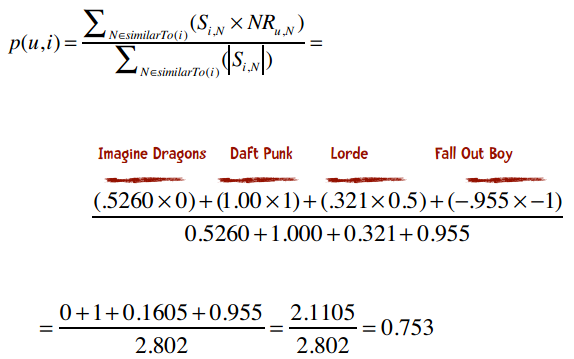

我们预测出David对Kacey Musgraves的评分是0.753，将其转换到5星评价体系中：
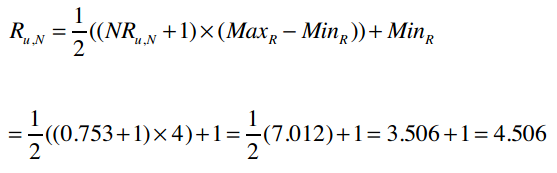

### Slope One算法
另一种流行的基于物品过滤的算法是Slope One。Slope One的一个主要优点是简洁性，因此它很容易实现。Slope One来自Daniel Lemire和Anna Machlachlan的论文《Slope One Predictors for Online Rating-Based Collaborative Filtering 》（http://www.daniel-lemire.com/fr/abstracts/SDM2005.html ）。这篇论文相当不错，值得阅读。

下面简要地给出该算法的基本知识。假设Amy给PSY打了3分，给Whitney Houston打了4分。而Ben给PSY打了4分，我们想预测Ben给Whitney Houston打的分数。该问题如下表所示：
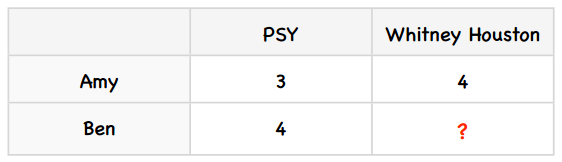

可以给出下面的推理过程。Amy给Whitney打的分数要比PSY高1分。因此，可以预计Ben也可能给Whitney的分数高1分，于是我们预测Ben会给Whitney打5分。

实际上有多个Slope One算法。接下来我们给出加权的Slope One（Weighted Slope One）算法。记住Slope One的一个主要优点是简单。而我们将给出的加权Slope One算法看起来复杂一些。

可以将Slope One看成两部分:
- 第一部分，事先（批处理模式）计算的部分，称为每对物品之间的偏差（deviation）。在上面提到的那个简单例子中，该过程会确定Whitney的得分会比 PSY高1分。经过第一部分的处理之后，就可以得到物品偏差构成的数据库
- 第二步我们进行实际的预测。比如Ben从没听过Whitney Houston的歌曲，我们想知道他会对Whitney打几分。利用他对所有乐队打的分数以及上述偏差矩阵，就可以进行预测

#### 第一部分：计算偏差
给出一个复杂些的数据：
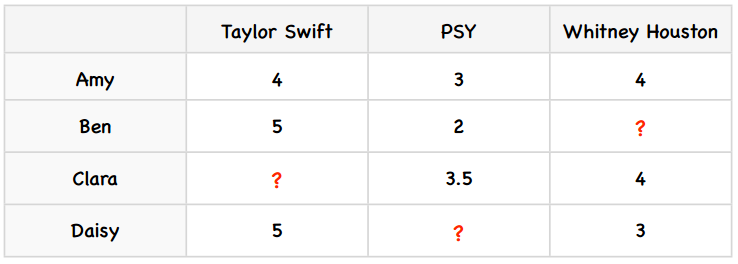


物品$i$到物品$j$的平均偏差为：
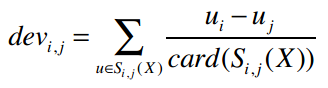

其中，$card(S_{j,i}(X))$表示同时评价过物品j和i的用户数。我们来考察PSY和Taylor Swift之间的差值，这个值是2——因为有两个用户（Amy和Ben）同时对PSY和Taylor Swift打过分。分子$u_j-u_i$表示用户对j的评分减去对i的评分，代入公式得：
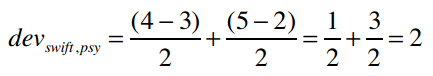

而PSY到Taylor Swift的距离为：
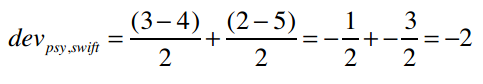

最终结果：
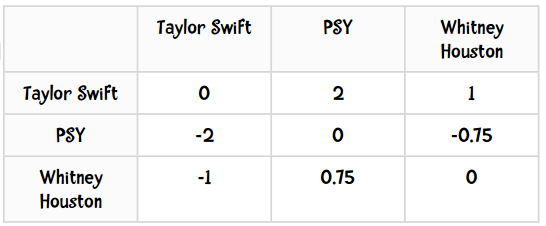

#### 第二部分：利用加权 Slope One 算法进行预测
我们将使用加权的Slope One算法来进行预测，用$P^{WS1}$来表示，公式为：
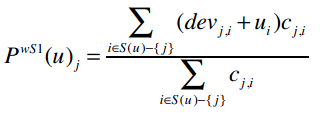

其中分母为：
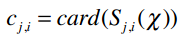

分子为：
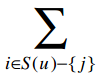
指的是对所有除$j$（这里是Whitney Houston）之外Ben打过分的乐队。

具体过程如下：
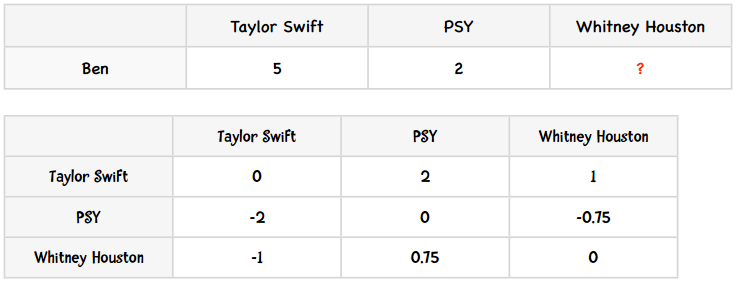

1. Ben曾经对Taylor Swift进行过评分，分值为5，这是$u_i$
2. Whitney Houston到Taylor Swift的偏差为-1，这是$dev_{j,i}$ 
3. 于是$dev_{j,i}+u_i$为 4。
4. 有两个人 (Amy 和 Daisy)同时对Taylor Swift和Whitney Houston进行了评分，因此$c_{j,i}=2$
5. 于是$(dev_{j,i}+u_i)c_{j,i} = 4×2 = 8$
6. Ben对PSY进行过评分，分值为2
7. Whitney Houston到PSY的偏差为0.75。
8. 于是$dev_{j,i}+u_i$为2.75。
9. 有两个用户同时对Whitney Houston和PSY进行了评分，因此$(dev_{j,i}+u_i)c_{j,i} = 2.75×2=5.5$
10. 将第5步和第9步的结果相加得到13.5，这是分子的计算结果
11. 分母计算的是，对于每个Ben评过分的乐队，将所有同时对两个乐队评过分的用户数目进行累加。Ben对Taylor Swift评过分，而同时对Taylor Swift和Whitney Houston评过分的用户数目为2；Ben也对PSY评过分，而同时对PSY和Whitney Houston评过分的用户数目也是2。于是分母的结果为4
12. 所以，Ben对Whitney Houston的评分预测值为$\frac{13.5}{4} = 3.375$

### 基于Slope One算法的推荐模块
参考我的github代码库

### MovieLens数据集
参考我的github代码库